In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec 
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn
import nltk
import re 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_score, recall_score,f1_score


from os import getcwd, chdir
import pandas as pd
import pickle as pk

encoding="utf-8"

In [4]:
trainset = pk.load(open("/content/gdrive/My Drive/NMSM/day2/trainset.pk","rb"))
testset = pk.load(open("/content/gdrive/My Drive/NMSM/day2/testset.pk","rb"))

GLOVE_6B_100D_PATH = "/content/gdrive/My Drive/NMSM/day2/glove.6B.100d.txt"

X_train = [t[0].split() for t in trainset]
X_test = [t[0].split() for t in testset]

X = X_train + X_test

Y_train = [t[1] for t in trainset]
Y_test = [t[1] for t in testset]

y = Y_train + Y_test

X[:1]
len(X)

X, y = np.array(X), np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
#MeanEmbeddingVectorizer define the way to represent docs using word vectors

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
            #self.dim=len(word2vec["and"])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [6]:
#Prepare word embeddings from GLOVE
import numpy as np
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

In [7]:
# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our data set
import struct 

glove_small = {}
all_words = set(w for words in X for w in words)

print(len(all_words))

with open(GLOVE_6B_100D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

95586


In [8]:
#Prepare word embeddings by training from dataset
model = Word2Vec(X, size=100, window=5, min_count=2, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#define the competing models 

# SVM + tfidf based bag-of-words features
#svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("svc", SVC(kernel="linear",C=10.0))])

svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("LR",LogisticRegression(random_state=0, solver='lbfgs'))])

# SVM + vec_from_dataset + MeanEmbedding
svc_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), ("LR",LogisticRegression(random_state=0, solver='lbfgs'))])


# SVM + GLOVE vectors + MeanEmbedding
svc_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), ("LR",LogisticRegression(random_state=0, solver='lbfgs'))])


In [10]:
#Predict using tfidf feature
svc_model = svc_tfidf.fit(X_train,Y_train)
svc_pred = svc_model.predict(X_test)
conf_mat = confusion_matrix(Y_test, svc_pred)
print ("SVC:\n",conf_mat)
print(metrics.classification_report(Y_test, svc_pred))

SVC:
 [[1571  226]
 [ 373 1627]]
              precision    recall  f1-score   support

          -1       0.81      0.87      0.84      1797
           1       0.88      0.81      0.84      2000

    accuracy                           0.84      3797
   macro avg       0.84      0.84      0.84      3797
weighted avg       0.84      0.84      0.84      3797



In [11]:
#Predict using pre-trained glove model
svc_glove_model = svc_glove_small.fit(X_train,Y_train)
svc_glove_pred = svc_glove_model.predict(X_test)
conf_mat = confusion_matrix(Y_test, svc_glove_pred)
print ("SVC_glove:\n",conf_mat)
print(metrics.classification_report(Y_test, svc_glove_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


SVC_glove:
 [[1476  321]
 [ 630 1370]]
              precision    recall  f1-score   support

          -1       0.70      0.82      0.76      1797
           1       0.81      0.69      0.74      2000

    accuracy                           0.75      3797
   macro avg       0.76      0.75      0.75      3797
weighted avg       0.76      0.75      0.75      3797



In [12]:
#Predict using self-trained word2vec
svc_w2v_model = svc_w2v.fit(X_train,Y_train)
svc_w2v_pred = svc_w2v_model.predict(X_test)
conf_mat = confusion_matrix(Y_test, svc_w2v_pred)
print ("SVC_w2v:\n",conf_mat)
print(metrics.classification_report(Y_test, svc_w2v_pred))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


SVC_w2v:
 [[1443  354]
 [ 545 1455]]
              precision    recall  f1-score   support

          -1       0.73      0.80      0.76      1797
           1       0.80      0.73      0.76      2000

    accuracy                           0.76      3797
   macro avg       0.77      0.77      0.76      3797
weighted avg       0.77      0.76      0.76      3797



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

[Text(0, 0.5, 'accuracy')]

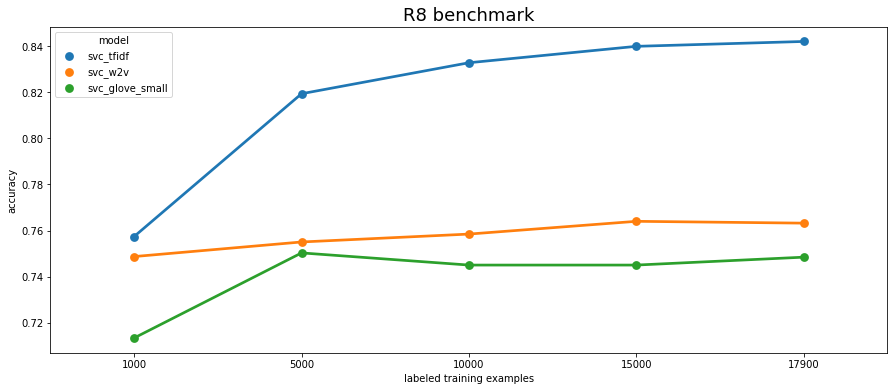

In [13]:
# benchmark all the models
all_models = [
    ("svc_tfidf", svc_tfidf),
    ("svc_w2v", svc_w2v),
    ("svc_glove_small",svc_glove_small)
]

##how the ranking depends on the amount of training data
def benchmark(model, X, y, n,X_test,y_test):
    scores = []
    sss = StratifiedShuffleSplit(n_splits=5, train_size=n,test_size =len(y)-n )
    
    for train, test in sss.split(X, y):
        X_train = X[train]
        y_train = y[train]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
        break
    return np.mean(scores)

train_sizes = [1000,5000,10000,15000,17900]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, np.array(X_train), np.array(Y_train), n,X_test, Y_test), 
                      'train_size': n})
df = pd.DataFrame(table)

plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["svc_tfidf", "svc_w2v", "svc_glove_small", ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")

In [27]:
#get the Kbest feature from Ngrams+Negation
ch21 = SelectKBest(chi2, k=100)
train_Kbest = []

In [29]:
import re 
def nega_tag(text):
    transformed = re.sub(r"\b(?:never|nothing|nowhere|noone|none|not|haven't|hasn't|hasnt|hadn't|hadnt|can't|cant|couldn't|couldnt|shouldn't|shouldnt|won't|wont|wouldn't|wouldnt|don't|dont|doesn't|doesnt|didn't|didnt|isnt|isn't|aren't|arent|aint|ain't|hardly|seldom)\b[\w\s]+[^\w\s]", lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), text, flags=re.IGNORECASE)
    return(transformed)



train_set_nega = []
for doc in trainset:
    trans = nega_tag(doc[0])
    lab = doc[1]
    train_set_nega.append([trans, lab])

X_nega_train = [t[0] for t in train_set_nega]
Y_nega_train = [t[1] for t in train_set_nega]

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
train_nega_vectors = vectorizer.fit_transform(X_nega_train)

ch21 = SelectKBest(chi2, k=100)
train_Kbest = ch21.fit_transform(train_nega_vectors, Y_nega_train)


In [39]:
train_Kbest_new=train_Kbest.toarray()

In [40]:
#define the embedding
w2v_Embedding = MeanEmbeddingVectorizer(w2v)
glove_Embedding = MeanEmbeddingVectorizer(glove_small)

In [41]:
#grab w2v feature
X_w2v_train = w2v_Embedding.transform(X_train)
X_w2v_train.shape

(17933, 100)

In [42]:
#grab glove feature
X_glove_train = glove_Embedding.transform(X_train)
X_glove_train.shape


(17933, 100)

In [44]:
#combine the feature set
final_train = np.c_[X_w2v_train,X_glove_train,train_Kbest_new]
final_train.shape


(17933, 300)

In [53]:
test_set_nega = []

# Append elements to the list
for doc in testset:
    trans = nega_tag(doc[0])
    lab = doc[1]
    test_set_nega.append([trans, lab])

X_nega_test = [t[0] for t in test_set_nega]
test_nega_vectors = vectorizer.transform(X_nega_test)
test_Kbest = ch21.transform(test_nega_vectors)


Y_nega_test = [t[1] for t in test_set_nega]

In [61]:
#Train the Classifiers
#Evaluate on the features frmo of test data  
from sklearn import svm
from sklearn.svm import LinearSVC

model_svm = LinearSVC(C=200)
sv = model_svm.fit(train_Kbest_new, Y_nega_train)
predSVM= sv.predict(test_Kbest)
pred = list(predSVM)

print(metrics.confusion_matrix(Y_nega_test, pred))
print(np.mean(predSVM == Y_nega_test) )
print(metrics.classification_report(Y_nega_test, pred))

selected_features = list(np.array(vectorizer.get_feature_names())[ch21.get_support()])
print (selected_features)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[[1563  234]
 [ 473 1527]]
0.8138003687121411
              precision    recall  f1-score   support

          -1       0.77      0.87      0.82      1797
           1       0.87      0.76      0.81      2000

    accuracy                           0.81      3797
   macro avg       0.82      0.82      0.81      3797
weighted avg       0.82      0.81      0.81      3797

['always', 'amazing', 'and great', 'asked', 'awesome', 'awful', 'bad', 'bagels', 'best', 'best pizza', 'best thai', 'bianco', 'bland', 'burger', 'cold', 'crispy', 'crispy duck', 'curry', 'definitely', 'delicious', 'didn', 'disappointed', 'drunken', 'dry', 'duck', 'ever had', 'excellent', 'fantastic', 'favorite', 'fresh', 'friendly', 'friendly and', 'garlic', 'great', 'great food', 'great place', 'great service', 'hands down', 'highly recommend', 'horrible', 'is', 'is always', 'is amazing', 'is great', 'lotus', 'lotus of', 'love', 'love the', 'love this', 'loved', 'manager', 'mediocre', 'minutes', 'my favorite', 'neg_aga